<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Analysis of Model Predictions

A `MoonshotML` strategy encompasses both the model's training and predictions and what we choose to do with those predictions in our trading logic. That's a lot to worry about in the initial research stage. To separate concerns, we can retrieve the model predictions from our backtest results and analyze the predictions in a notebook, which might illuminate how we want to use the predictions.

## Retrieve predictions and prices


In `predictions_to_signals`, we save the predictions, closing prices, and volume DataFrames to the backtest results: 

```python
...
# Save the predictions and prices so we can analyze them
self.save_to_results("Prediction", predictions)
self.save_to_results("Close", closes)
self.save_to_results("Volume", volumes)
...
```

To get these fields back, we must re-run the walk-forward optimization with `details=True`:

In [1]:
from quantrocket.moonshot import ml_walkforward
ml_walkforward("kitchensink-ml",
                start_date="2006-12-31",
                end_date="2018-12-31",
                train="Y",
                details=True,
                model_filepath="pca_sgd_model.joblib",
                progress=True,
                filepath_or_buffer="kitchensink_ml_details*")

## Load predictions and prices

Using `details=True` on a large universe results in a large backtest results CSV. To make it easier to load, we use `csvgrep` to isolate particular fields before we load anything into memory:

In [2]:
!csvgrep -c Field -m Prediction kitchensink_ml_details_results.csv > kitchensink_ml_details_results_Prediction.csv
!csvgrep -c Field -m Close kitchensink_ml_details_results.csv > kitchensink_ml_details_results_Close.csv
!csvgrep -c Field -m Volume kitchensink_ml_details_results.csv > kitchensink_ml_details_results_Volume.csv

Then we load only these fields:

In [3]:
import pandas as pd
predictions = pd.read_csv("kitchensink_ml_details_results_Prediction.csv", parse_dates=["Date"], index_col=["Field","Date"]).loc["Prediction"]
closes = pd.read_csv("kitchensink_ml_details_results_Close.csv", parse_dates=["Date"], index_col=["Field","Date"]).loc["Close"]
volumes = pd.read_csv("kitchensink_ml_details_results_Volume.csv", parse_dates=["Date"], index_col=["Field","Date"]).loc["Volume"]

Let's split our predictions into 5 bins and compare one-week forward returns for each bin:

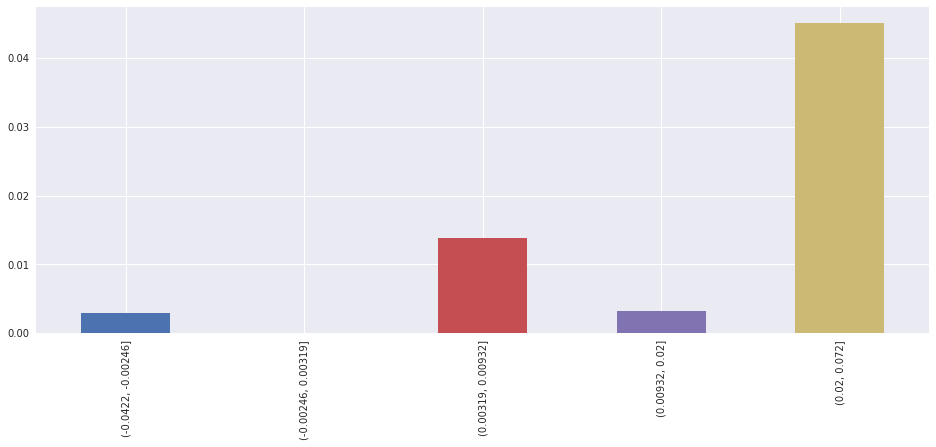

In [4]:
# Calculate one week returns
one_week_returns = (closes - closes.shift(5)) / closes.shift(5)

# Shift one week returns back to time of prediction, and stack returns and predictions 
one_week_forward_returns_stacked = one_week_returns.shift(-5).stack(dropna=False)
predictions_stacked = predictions.stack(dropna=False)

# Bin predictions into 5 equal-size bins
prediction_bins = pd.qcut(predictions_stacked, 5)

# Plot returns by bin
one_week_forward_returns_stacked.groupby(prediction_bins).mean().plot(kind="bar")

The stocks with the higest predicted return indeed have the highest forward return. The stocks with the lowest predicted return have a lower but still positive forward return. This suggests it may be possible to dig deeper into the strategy and figure out why, despite this forward return profile, the backtest performance is poor.

***

[Back to Introduction](Introduction.ipynb)